# Выбор локации новой скважины в "ГлавРосГосНефть"

**Цель** - определить перспективный регион для добычи. 

**Задачи:**
  - В избранном регионе собрать характеристики для скважин: качество нефти и объём её запасов;
  - Построить модель для предсказания объёма запасов в новых скважинах;
  - Выбрать скважины с самыми высокими оценками значений;
  - Определить регион с максимальной суммарной прибылью отобранных скважин.

## Входные данные о запасах в трёх регионах
Признаки:
- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три признака скважин
- `product` — объём запасов в скважине (тыс. баррелей)

## Содержание <a id="contents">
    
1. [Изучение и обработка входных данных](#EDA)
  - 1.1 [Проверка на дубликаты](#dublicates)
  - 1.2 [Проверка на пропуски](#omissions)
  - 1.3 [Предобработка признаков](#preprocessing)
  - 1.4 [Проверка на отсутствие мультиколлинеарности признаков](#multi)
  - 1.5 [Проверка на нормальность распределения](#norm)
  - 1.6 [Выводы](#conlusions_eda)

    
2. [Разделение данных на выборки и расчет среднего запаса сырья в регионе](#selection)
    
    
3. [Расчет среднего объема сырья для безубыточной разработки новой скважины](#barrels_per_oiler)
    
    
4. [Расчёт прибыли по выбранным скважинам и предсказаниям модели](#top200_oilers)
    
    
5. [Расчёт рисков и прибыли для каждого региона с применением техники Bootstrap](#loss_profit)
    
    
6. [Заключение](#summary)


## 1. Изучение и обработка входных данных <a id="EDA">
[вернуться к содержанию](#contents)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import cross_val_score

from scipy import stats as st
import pylab 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown as md
from tqdm.notebook import tqdm

In [29]:
path = '/datasets/'
region1 = pd.read_csv(path + 'geo_data_0.csv')
region2 = pd.read_csv(path + 'geo_data_1.csv')
region3 = pd.read_csv(path + 'geo_data_2.csv')
display(region1.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [30]:
region1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### 1.1 Проверка на дубликаты  <a id="dublicates">

In [31]:
for region in [region1, region2, region3]:
    display(region1.duplicated().sum())

0

0

0

- дубликатов нет

### 1.2 Проверка на пропуски <a id="omissions">
Представим в виде тепловой карты для общей визуализации количества пропусков

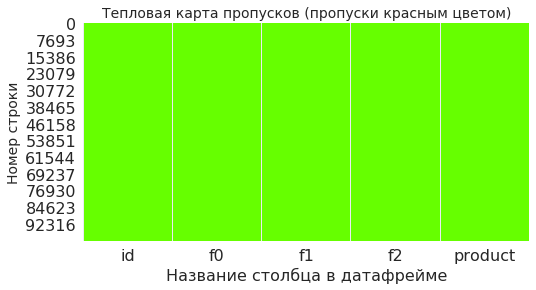

In [32]:
# зеленым цветом (#66ff00) - непропущенные, красным цветом (#d41243) - пропущенные данные 
colors = ['#66ff00', '#d41243'] 
fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(region1.isna(), cmap=sns.color_palette(colors), cbar=False, ax=ax)
plt.xlabel('Название столбца в датафрейме', fontsize=16)
plt.ylabel('Номер строки', fontsize=14)
plt.title('Тепловая карта пропусков (пропуски красным цветом)', fontsize=14)
plt.show()

In [33]:
# на наличие NaN значений, в относительном выражении
for region in [region1, region2, region3]:
    print(region1.isna().mean())

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64


In [34]:
# на наличие пропусков как строковых значений
for region in [region1, region2, region3]:
    print(region1.isin(['-', 'None', 'Null', ' ']).sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


- пропущенных значений нет, все ок

### 1.3 Предобработка признаков <a id="preprocessing">
Удалим неинформативный лишний для линейной регрессии столбец с id скважины

In [35]:
region1 = region1.drop('id', axis=1)
region2 = region2.drop('id', axis=1)
region3 = region3.drop('id', axis=1)

# присвоим имена датафреймам, потребуются для графиков
region1.name = 'Регион №1'
region2.name = 'Регион №2'
region3.name = 'Регион №3'

(region1.head()
        .style
        .set_caption('Скважины региона №1:')
        .set_table_styles([{'selector': 'caption', 
                            'props': [('color', 'blue'), ('font-size', '15px')]}
                           ]))


,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.28
1,1.33471,-0.340164,4.36508,73.0378
2,1.02273,0.15199,1.41993,85.2656
3,-0.0321716,0.139033,2.97857,168.621
4,1.98843,0.155413,4.75177,154.037


### 1.4 Проверка на отсутствие мультиколлинеарности признаков <a id="multi">

In [36]:
for region in [region1, region2, region3]:
    display(region.corr()
            .style
            .background_gradient(cmap='Blues')
            .format('{:.3f}')
            .set_caption('{}:'.format(region.name))
            .set_table_styles([{'selector': 'caption', 
                            'props': [('color', 'blue'), ('font-size', '15px')]}
                              ]))

# для себя https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.030
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.030,-0.010,0.999,1.000


,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


- между собой признаки `f0`, `f1`, `f2` слабо коррелируют (по крайней мере линейной связи не видим);
- видно значительное влияние на объемы сырья `product` признака `f2` в регионе №2.


### 1.5 Проверка на нормальность распределения <a id="norm">
Посмотрим на нормальность распределения признаков и целевой переменной, а также на наличие нелинейных связей

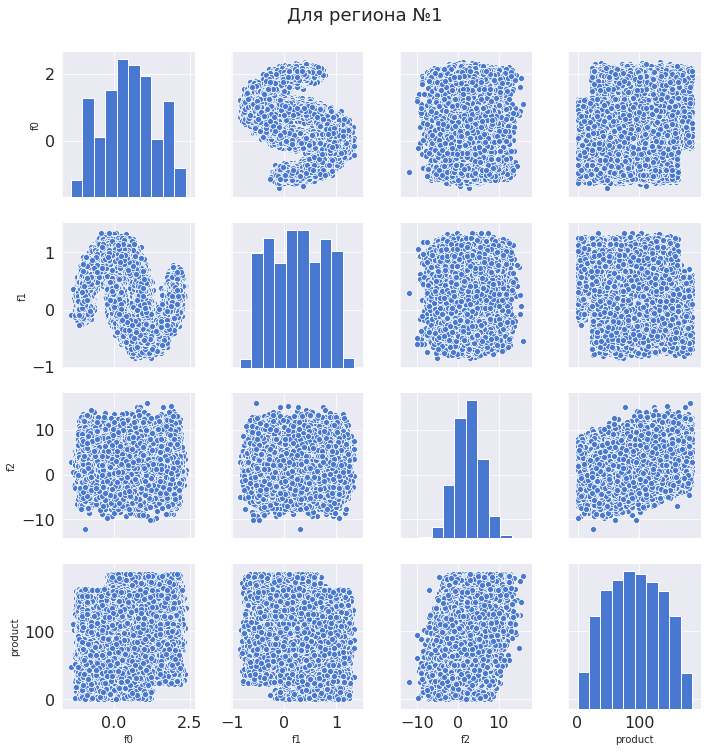

In [37]:
g = sns.pairplot(region1)
g.fig.suptitle("Для региона №1", y=1.04, fontsize=18)
plt.show()

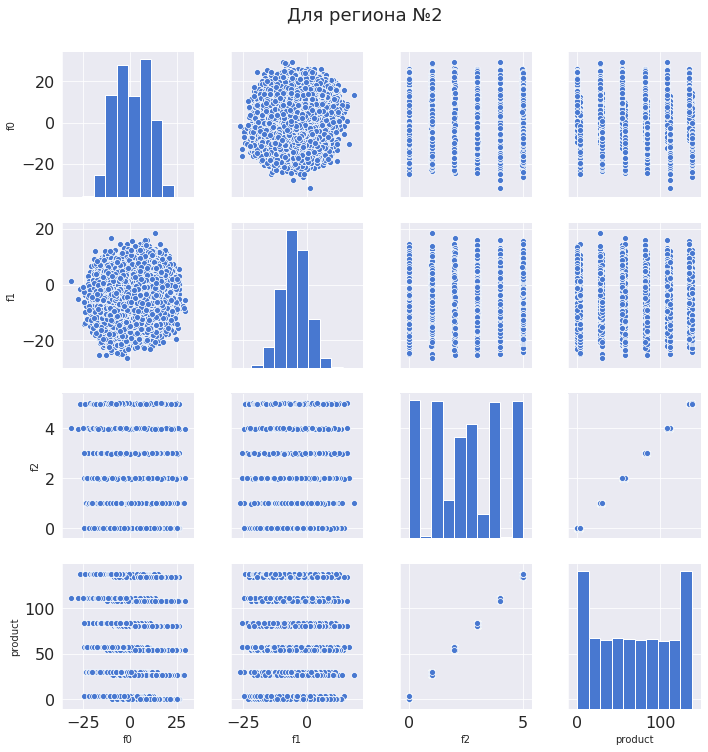

In [38]:
g = sns.pairplot(region2)
g.fig.suptitle("Для региона №2", y=1.04, fontsize=18)
plt.show()

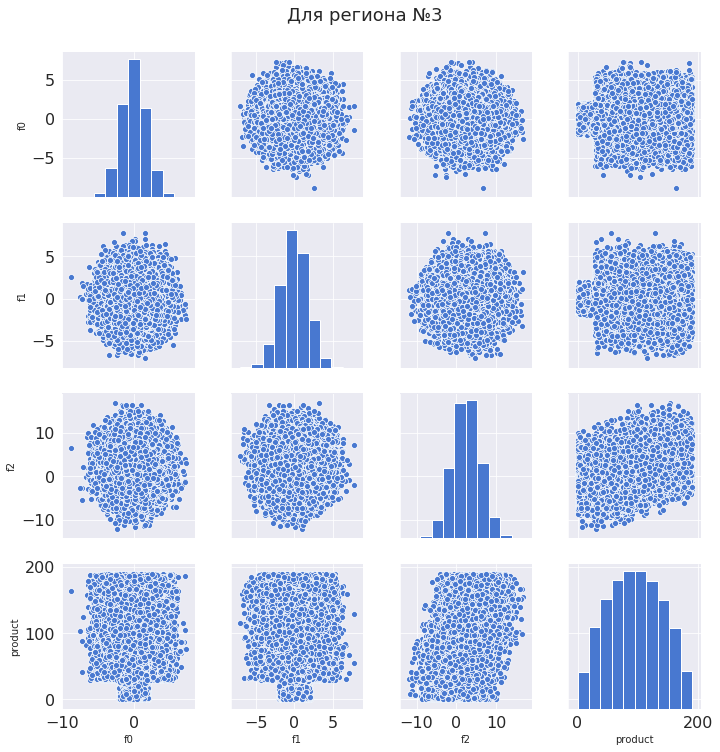

In [39]:
g = sns.pairplot(region3)
g.fig.suptitle("Для региона №3", y=1.04, fontsize=18)
plt.show()

- для региона №1 признаки `f0` и `f1` нелинейно (S-образно) связаны, оставим их как есть, посмотрим как с этим справится линейная регрессия;
- для региона №2 видна сильная взаимосвязь `f2` и `product`, скорее всего вес `f2`признака будет большой;
- посмотрим подробнее на отклонения от нормальности (для тренировки):

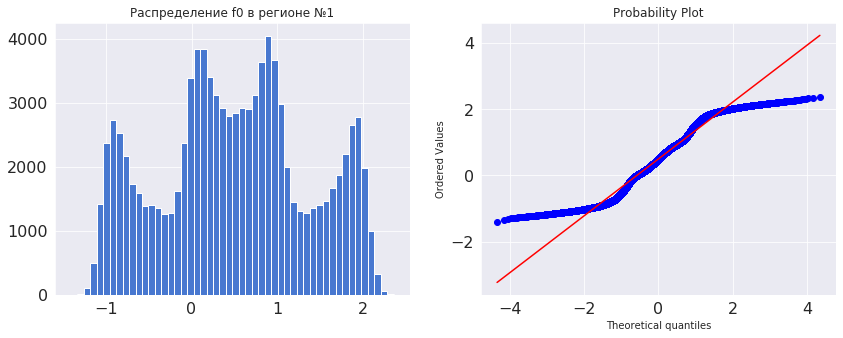

In [40]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
region1['f0'].hist(bins=50)
plt.title('Распределение f0 в регионе №1')

plt.subplot(1, 2, 2)
st.probplot(region1['f0'], dist="norm", plot=pylab)
plt.show()

# построение графиков https://notebook.community/grehujt/SmallPythonProjects/jupyterNotebooks/LinearRegression/LinearRegression

- и, например, нормальное распределение `f1` в регионе №2:

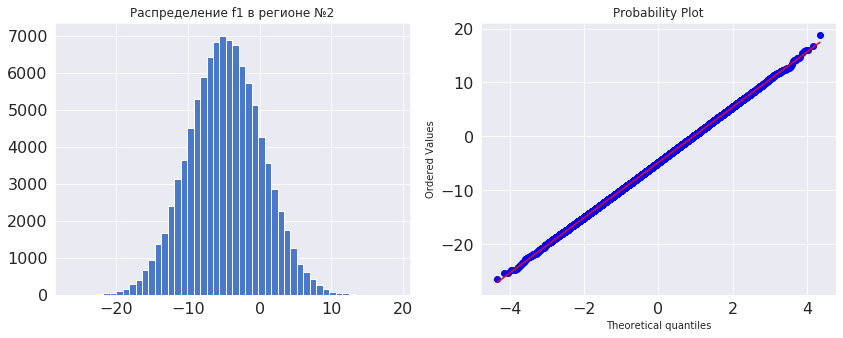

In [41]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
region2['f1'].hist(bins=50)
plt.title('Распределение f1 в регионе №2')

plt.subplot(1, 2, 2)
st.probplot(region2['f1'], dist="norm", plot=pylab)
plt.show()

### 1.6 Выводы <a id="conlusions_eda">
В исходных данных:
  - нет дубликатов и пропусков, 
  - есть изыбыточный для модели столбец с id скважины (удален), 
  - мультиколлинеарность признаков `f1`, `f2`, `f3` отсутствует, 
  - распределение признаков и целевой переменной похоже на нормальные, но есть существенные отклонения - оставим их как есть.

## 2. Разделение данных на выборки и расчет среднего запаса сырья в регионе <a id="selection">
[вернуться к содержанию](#contents)
    
Напишем функцию, которая разделяет данные на обучающую и валидационную выборки в пропорции 75%:25%, затем строит линейную регрессию, затем рассчитывает средний запас предсказанного сырья и его отклонение, а затем возвращает целевые и предсказанные объемы сырья.

In [42]:
def my_linear_regression(df, target_column):
    """работает для датасетов содержащих только количественные переменные"""
    # разбиваем на признаки и целевую переменную
    target = df[target_column]
    features = df.drop(target_column, axis=1)
    # выделяем обучающую и валидационную выборки в пропорции 75%:25%
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                    test_size=0.25, 
                                                                                    random_state=12345)
    
    # обучаем scaler на train выборке
    scaler = StandardScaler()
    scaler.fit(features_train) 
    # проводим стандартизацию количественных признаков
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
     
    # строим модель
    model = LinearRegression()   
    model.fit(features_train, target_train)
    target_predict = model.predict(features_valid)

    # смотрим среднее квадратичное отклонение
    mse = mean_squared_error(target_valid, target_predict)
    rmse = np.sqrt(mse)
    
    print('''1. Средний запас предсказанного сырья: {:.2f} тыс. баррелей,
2. Корень из средней квадратичной ошибки: {:.2f} тыс. баррелей'''.format(target_predict.mean(), rmse))
    
    return (target_valid.reset_index(drop=True),  # сбросим, чтобы было соответствие с индексами в target_predict
            pd.Series(target_predict)             # преобразуем в объект Series
           )

**Для региона №1:**

In [43]:
r1_target_valid, r1_target_predict = my_linear_regression(region1, target_column='product')

1. Средний запас предсказанного сырья: 92.59 тыс. баррелей,
2. Корень из средней квадратичной ошибки: 37.58 тыс. баррелей


**Для региона №2:**

In [44]:
r2_target_valid, r2_target_predict = my_linear_regression(region2, target_column='product')

1. Средний запас предсказанного сырья: 68.73 тыс. баррелей,
2. Корень из средней квадратичной ошибки: 0.89 тыс. баррелей


**Для региона №3:**

In [45]:
r3_target_valid, r3_target_predict = my_linear_regression(region3, target_column='product')

1. Средний запас предсказанного сырья: 94.97 тыс. баррелей,
2. Корень из средней квадратичной ошибки: 40.03 тыс. баррелей


### Выводы
По среднему запасу предсказанного сырья сильно выделяются регионы №1 и №3 - почти на 30% больше, чем в регионе №2. С этой точки зрения регион №2 кажется наименее приоритетным. Однако разброс значений для регионов №1 и №3 весьма значительный, в то мвремя как для региона №2 модель довольно точно описывает запасы.

## 3. Расчет среднего объема сырья для безубыточной разработки новой скважины <a id="barrels_per_oiler">
[вернуться к содержанию](#contents)
    
Запишем необходимые переменные и рассчитаем средний объем сырья в одной скважине для её окупаемости.

In [46]:
# при разведке региона исследуют 500 точек
oiler_researched = 500
# выбирают 200 лучших для расчёта прибыли.
oilers_limit = 200

# один баррель сырья приносит 450 рублей дохода
revenue_per_barrel = 450 
# доход с тысячи баррелей
revenue_per_1000barrel = revenue_per_barrel * 1000  

# бюджет на разработку скважин в регионе составляет 10 млрд рублей
region_budget = 10E+9


# бюджет на одну из 200 скважин
budget_per_oiler = region_budget / oilers_limit
print('Бюджет на одну скважину: {} млн.руб.'.format(budget_per_oiler / 1E+6))

# в среднем в каждой такой скважине должно быть тыс.баррелей, чтобы окупить её бюджет
barrels_per_oiler = budget_per_oiler / revenue_per_1000barrel
print('При цене 1 барреля в 450 руб для окупаемости необходимо количество нефти в одной такой скважине: {:.2f} тыс.баррелей'.format(barrels_per_oiler))


Бюджет на одну скважину: 50.0 млн.руб.
При цене 1 барреля в 450 руб для окупаемости необходимо количество нефти в одной такой скважине: 111.11 тыс.баррелей


- необходимо чтобы в среднем в каждой скважине находилось 111.11 тысяч баррелей нефти;
- сравним полученный средний объём сырья для окупаемости со средним запасом в каждом регионе:

In [47]:
for region in [region1, region2, region3]:
    print('Средний объем сырья в скважине в {} составляет {} тыс.баррелей'.format(
                                                                            region.name, 
                                                                            round(region['product'].mean(), 1))
          )

Средний объем сырья в скважине в Регион №1 составляет 92.5 тыс.баррелей
Средний объем сырья в скважине в Регион №2 составляет 68.8 тыс.баррелей
Средний объем сырья в скважине в Регион №3 составляет 95.0 тыс.баррелей


### Выводы
На данном этапе сложно сказать какой регион предпочтительнее. Средний объем сырья в скважине в каждом регионе меньше точки безубыточности - тем более важно выделить в каждом регионе 200 наиболее преспективных скважин, чтобы добыча была рентабельной.
Наиболее адекватно модель описывает запасы сырья для региона №2, здесь оценка запасов имеет наименьшее отклонение.

## 4. Расчёт прибыли по выбранным скважинам и предсказаниям модели <a id="top200_oilers">
[вернуться к содержанию](#contents)
    
Создадим функцию, которая сортирует скважины в данном регионе по предсказанным объемам сырья, отбирает 
заданное количество лучших и по целевым значениям для топ-200 скважин считает прибыль. 
- предсказания объемов нефти для трех регионов записаны в `r1_target_predict`, `r2_target_predict`, `r3_target_predict`
- целевые значения объемов для трех регионов записаны в `r1_target_valid`, `r2_target_valid`, `r3_target_valid`

In [48]:
def profit_by_region(region_target_predict, region_target_valid, oilers_limit):
    """возвращает прибыль от топ-200 предсказанных скважин"""
    # выбираем топ-200 скважин по предсказаниям
    region_top200_predict = region_target_predict.sort_values(ascending=False).head(oilers_limit)
    
    # считаем суммарный объем нефти по целевым значениям для топ-200 предсказанных скважин
    region_top200_target_volume = region_target_valid[region_top200_predict.index].sum()
    
    # считаем прибыль как объем в тыс. баррелях умноженный на стоимость тысячи баррелей 
    # за вычетом бюджета на разработку 200 скважин
    region_profit = region_top200_target_volume * revenue_per_1000barrel - region_budget
    
    return region_profit

## 5. Расчёт рисков и прибыли для каждого региона с применением техники Bootstrap <a id="loss_profit">
[вернуться к содержанию](#contents)
    
Техникой Bootstrap строим распределение прибыли, для этого:
- из всех скважин 1000 раз берем выборку в 500 скважин;
- среди этих 500 скважин выбираем топ-200 скважин с наибольшими запасами;
- по каждой такой топ-200 выборке считаем прибыль при заданной цене барреля;
- находим среднюю прибыль, 95%-й доверительный интервал и риск убытков (убыток — это отрицательная прибыль);
- после оценки рисков оставляем лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбираем регион с наибольшей средней прибылью.

In [49]:
def bootstrapped_profit(region_target_predict,
                       region_target_valid,
                       oilers_limit, bootstrap_limit):
    state = np.random.RandomState(12345)
    profit_values = []

    for i in tqdm(range(bootstrap_limit)):
        # выбираем случайные 500 скважин из тех, по которым есть предсказания  
        region_predict_subsample = region_target_predict.sample(n=500, 
                                                        replace=True, 
                                                        random_state=state)

        # выбираем целевые объемы для данных 500 скважин
        region_valid_subsample = region_target_valid[region_predict_subsample.index]

        # считаем прибыль для топ-200 из этих 500 скважин
        profit_values.append(profit_by_region(region_predict_subsample, 
                                              region_valid_subsample,
                                              oilers_limit))
        
    # запишем прибыль в млн. руб.
    profit_values = pd.Series(profit_values) / 1E+6 
    
    mean_profit = profit_values.mean()
    median_profit = profit_values.median()
    
    lower = round(profit_values.quantile(0.025), 2)
    upper = round(profit_values.quantile(0.975), 2)
    
    
    #график распределения прибыли
    plt.figure(figsize=(7,4))
    sns.distplot(profit_values, bins=50, color='blue', kde=True)
    plt.xlabel('Распределение прибыли от топ-200 скважин, млн.руб', fontsize=16)
    plt.axvline(mean_profit, color='r', linestyle='--')
    plt.axvline(median_profit, color='g', linestyle='-')
    plt.legend({'mean_profit':mean_profit,'median_profit':median_profit}, fontsize=14)
    plt.show()
    
    print('Средняя прибыль: {:.2f} млн.руб'.format(mean_profit))
    print('95% доверительный интервал для прибыли: от {} до {} млн.руб'.format(lower, upper))
    
    
    # находим вероятность убытков
    # https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
    profit_values = profit_values.value_counts().reset_index()
    profit_values.columns = ['profit', 'frequency']
    profit_values = profit_values.sort_values(by='profit')
    
    # плотность вероятности для дискретных величин (PDF)
    profit_values['pdf'] = profit_values['frequency'] / sum(profit_values['frequency'])
    # кумулятивная функция распределения (CDF)
    profit_values['cdf'] = profit_values['pdf'].cumsum()
    profit_values = profit_values.reset_index(drop=True)
    
    # ищем убытки и считаем вероятность 
    loss = profit_values[profit_values['profit'] <= 0]
    display(loss.tail()
                .style
                .format('{:.2%}', subset='cdf')
                .highlight_max(subset='cdf')
                .set_caption('Вероятность убытков:')
                .set_table_styles([{'selector': 'caption', 
                                    'props': [('color', 'blue'), ('font-size', '15px')]}
                                  ]))
    print('Вероятность убытков: {:.2%}'.format(loss['cdf'].max()))
    

**для региона №1:**

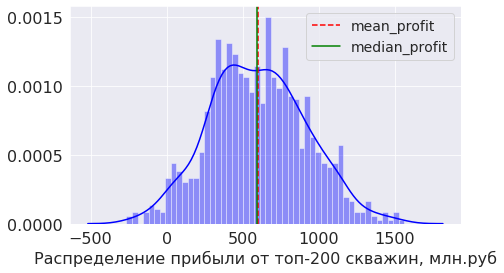

Средняя прибыль: 600.74 млн.руб
95% доверительный интервал для прибыли: от 12.95 до 1231.16 млн.руб


,profit,frequency,pdf,cdf
15,-70.7628,1,0.001,1.60%
16,-51.8924,1,0.001,1.70%
17,-39.7453,1,0.001,1.80%
18,-37.9223,1,0.001,1.90%
19,-26.4511,1,0.001,2.00%


Вероятность убытков: 2.00%
CPU times: user 5.36 s, sys: 130 ms, total: 5.49 s
Wall time: 5.92 s


In [50]:
%%time
bootstrapped_profit(r1_target_predict, 
                    r1_target_valid, 
                    oilers_limit=oilers_limit,
                    bootstrap_limit=1000)

**для региона №2:**

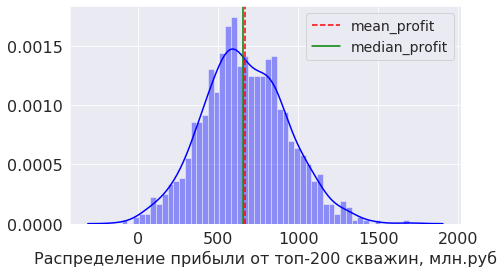

Средняя прибыль: 665.24 млн.руб
95% доверительный интервал для прибыли: от 157.99 до 1197.64 млн.руб


,profit,frequency,pdf,cdf
0,-105.935,1,0.001,0.10%
1,-15.3096,1,0.001,0.20%
2,-7.4724,1,0.001,0.30%


Вероятность убытков: 0.30%
CPU times: user 5.24 s, sys: 210 ms, total: 5.45 s
Wall time: 5.8 s


In [51]:
%%time
bootstrapped_profit(r2_target_predict, 
                    r2_target_valid, 
                    oilers_limit=oilers_limit,
                    bootstrap_limit=1000)

**для региона №3:**

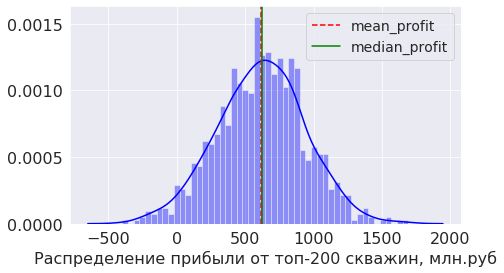

Средняя прибыль: 615.56 млн.руб
95% доверительный интервал для прибыли: от -12.22 до 1230.64 млн.руб


,profit,frequency,pdf,cdf
25,-12.1147,1,0.001,2.60%
26,-11.0279,1,0.001,2.70%
27,-4.02937,1,0.001,2.80%
28,-1.83228,1,0.001,2.90%
29,-0.75126,1,0.001,3.00%


Вероятность убытков: 3.00%
CPU times: user 5.32 s, sys: 147 ms, total: 5.47 s
Wall time: 5.81 s


In [52]:
%%time
bootstrapped_profit(r3_target_predict, 
                    r3_target_valid, 
                    oilers_limit=oilers_limit,
                    bootstrap_limit=1000)

<table width="100%" border="1" cellpadding="4" cellspacing="0">
   <caption>Сводная таблица характеристик регионов, посчитанных по топ-200 скважинам </caption>
    <tr>
        <td> <b>Номер региона</td>
        <td> <b>Средняя прибыль, млн.руб</td>
        <td> <b>95% доверительный интервал прибыли </td>
        <td> <b>Вероятность убытков </td>
    </tr>
    <tr>
        <td> <b>№1 </td>
        <td> 600.74 </td>
        <td> от 12.95 до 1231.16 млн.руб </td>
        <td> 2.00%</td>
    </tr>
    <tr>
        <td> <b>№2 </td>
        <td> 665.24 </td>
        <td> от 157.99 до 1197.64 млн.руб</td>
        <td> 0.30%</td>
    </tr>
    <tr>
        <td> <b>№3 </td>
        <td> 615.56 </td>
        <td> от -12.22 до 1230.64 млн.руб</td>
        <td> 3.00%</td>
    </tr>
</table>

### Выводы
Таким образом, в регионе №3 имеем вероятность убытков в 3.0%, что выше порогового значения в 2.5%. Его исключаем из рассмотрения.
Из двух остальных регионов наибольшую среднюю прибыль имеет регион №2, к тому же для него вероятность убытко ниже. А также для него наиболее высокое значение низшей границы доверительного интервала прибыли 157.99 млн.руб.


## Заключение <a id="summary">
[вернуться к содержанию](#contents) 
    
Таким образом, по результатам анализа данных о скважинах в трех регионах с использованием техники Bootstrap можно сказать, что наиболее переспективный регион №2. В нем наименьшие риски 0.3%, наиболее высокая средняя прибыль 665 млн.руб.